In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
import warnings
from tcn import TCN

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Input
warnings.filterwarnings("ignore")
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Importing the data

In [3]:
assessments = pd.read_csv('assessments.csv').drop_duplicates()
courses = pd.read_csv('courses.csv').drop_duplicates()
student_assessment = pd.read_csv('studentAssessment.csv').drop_duplicates()
student_info = pd.read_csv('studentInfo.csv').drop_duplicates()
student_registration = pd.read_csv('studentRegistration.csv').drop_duplicates()
student_vle = pd.read_csv('studentsvle.csv').drop_duplicates()
vle = pd.read_csv('vle.csv').drop_duplicates()

In [4]:
print(len(assessments))
assessments.head(2)

206


,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0


In [5]:
print(len(assessments))
print(assessments['assessment_type'].value_counts())
print(assessments['code_presentation'].value_counts())

206
assessment_type
TMA     106
CMA      76
Exam     24
Name: count, dtype: int64
code_presentation
2014J    57
2014B    57
2013J    53
2013B    39
Name: count, dtype: int64


In [6]:
print(len(courses))
courses.head(2)

22


,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269


In [7]:
print(len(student_info))
student_info.tail(2)

32593


,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
32591,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,Withdrawn
32592,GGG,2014J,2684003,F,Yorkshire Region,HE Qualification,50-60%,35-55,0,30,N,Distinction


In [8]:
print(len(student_registration))
student_registration.head(2)

32593


,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN


In [9]:
print(len(student_vle))
student_vle.head(2)

9868110


,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1


In [10]:
max_click = student_vle.drop('date',axis = 1)
max_click = max_click.groupby(['code_module','code_presentation','id_student']).agg({'sum_click':'max',
                                                                                    'id_site':'nunique'}).reset_index()
max_click.head()

,code_module,code_presentation,id_student,sum_click,id_site
0,AAA,2013J,11391,76,55
1,AAA,2013J,28400,23,84
2,AAA,2013J,30268,23,22
3,AAA,2013J,31604,22,82
4,AAA,2013J,32885,22,66


In [11]:
print(len(vle))
vle.head()

6364


,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN


### Data Preprocessing

In [12]:
#Merging students' information and registration
student_merge = pd.merge(student_info,student_registration, on = ['code_module','code_presentation','id_student'])
student_merge.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,-159.0,NaN
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,-53.0,NaN
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,-92.0,12.0
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,-52.0,NaN
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,-176.0,NaN


In [13]:
#Merging the courses, assessments and student assessment together
#Result of the students' performance
assessments_dum = pd.merge(assessments,courses,on = ['code_module','code_presentation'])
assessments_merge = pd.merge(assessments_dum,student_assessment,on = 'id_assessment')
assessments_merge['e_l_submission'] = assessments_merge['date'] - assessments_merge['date_submitted']
assessments_merge.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight,module_presentation_length,id_student,date_submitted,is_banked,score,e_l_submission
0,AAA,2013J,1752,TMA,19.0,10.0,268,11391,18,0,78.0,1.0
1,AAA,2013J,1752,TMA,19.0,10.0,268,28400,22,0,70.0,-3.0
2,AAA,2013J,1752,TMA,19.0,10.0,268,31604,17,0,72.0,2.0
3,AAA,2013J,1752,TMA,19.0,10.0,268,32885,26,0,69.0,-7.0
4,AAA,2013J,1752,TMA,19.0,10.0,268,38053,19,0,79.0,0.0


In [14]:
ass_merge_group = assessments_merge.groupby(['code_module','code_presentation','assessment_type','id_student']).mean().reset_index()
print(len(ass_merge_group))
ass_merge_group.head()

44879


,code_module,code_presentation,assessment_type,id_student,id_assessment,date,weight,module_presentation_length,date_submitted,is_banked,score,e_l_submission
0,AAA,2013J,TMA,11391,1754.0,114.2,20.0,268.0,112.4,0.0,82.0,1.8
1,AAA,2013J,TMA,28400,1754.0,114.2,20.0,268.0,114.2,0.0,66.4,0.0
2,AAA,2013J,TMA,31604,1754.0,114.2,20.0,268.0,112.2,0.0,76.0,2.0
3,AAA,2013J,TMA,32885,1754.0,114.2,20.0,268.0,125.6,0.0,54.4,-11.4
4,AAA,2013J,TMA,38053,1754.0,114.2,20.0,268.0,116.2,0.0,68.0,-2.0


In [15]:
mod_stu_vle = student_vle.drop(columns = 'date')

In [16]:
stu_vle =mod_stu_vle.groupby(['id_student','code_module','code_presentation','id_site']).agg({
    'sum_click': 'sum'           # Sum total clicks per date
}).reset_index()

In [17]:
len(stu_vle)

1960496

In [18]:
stu_vle.head(10)

,id_student,code_module,code_presentation,id_site,sum_click
0,6516,AAA,2014J,877011,23
1,6516,AAA,2014J,877012,258
2,6516,AAA,2014J,877015,23
3,6516,AAA,2014J,877023,6
4,6516,AAA,2014J,877025,82
5,6516,AAA,2014J,877030,497
6,6516,AAA,2014J,877031,16
7,6516,AAA,2014J,877032,11
8,6516,AAA,2014J,877033,7
9,6516,AAA,2014J,877034,7


In [19]:
stu_vle.head()

,id_student,code_module,code_presentation,id_site,sum_click
0,6516,AAA,2014J,877011,23
1,6516,AAA,2014J,877012,258
2,6516,AAA,2014J,877015,23
3,6516,AAA,2014J,877023,6
4,6516,AAA,2014J,877025,82


In [20]:
#Merging the interaction information
#student_vle and vle
vle_merge = pd.merge(stu_vle,vle,on = ['id_site','code_module','code_presentation'])
vle_merge.head()

,id_student,code_module,code_presentation,id_site,sum_click,activity_type,week_from,week_to
0,6516,AAA,2014J,877011,23,forumng,NaN,NaN
1,6516,AAA,2014J,877012,258,forumng,NaN,NaN
2,6516,AAA,2014J,877015,23,forumng,NaN,NaN
3,6516,AAA,2014J,877023,6,forumng,NaN,NaN
4,6516,AAA,2014J,877025,82,forumng,NaN,NaN


In [21]:
len(vle_merge)

1960496

In [22]:
index_columns = ['code_module', 'code_presentation', 'id_student']
# Step 2: Check for 'id_student' in DataFrames
for df in [student_merge, vle_merge, ass_merge_group]:
    if index_columns[0] not in df.columns:
        raise KeyError(f"The column {index_columns[0]} is missing from one of the dataframes.")
    elif index_columns[1] not in df.columns:
        raise KeyError(f"The column {index_columns[1]} is missing from one of the dataframes.")
    elif index_columns[2] not in df.columns:
        raise KeyError(f"The column {index_columns[2]} is missing from one of the dataframes.")
    else:
        print('The primary keys are in all the merged tables')
        print(len(df))

The primary keys are in all the merged tables
32593
The primary keys are in all the merged tables
1960496
The primary keys are in all the merged tables
44879


In [23]:
full_info = pd.merge(student_merge, vle_merge, on = index_columns)

In [24]:
first_vle = student_vle.drop(columns = 'sum_click')
first_vle = student_vle.groupby(['id_student','code_module','code_presentation','id_site']).agg({'date':'min'}).reset_index()
print(len(first_vle))
first_vle.head()

1960496


,id_student,code_module,code_presentation,id_site,date
0,6516,AAA,2014J,877011,204
1,6516,AAA,2014J,877012,0
2,6516,AAA,2014J,877015,50
3,6516,AAA,2014J,877023,0
4,6516,AAA,2014J,877025,-22


In [25]:
full_info.shape

(1960496, 19)

In [26]:
full_info = pd.merge(full_info, ass_merge_group, on = index_columns)

In [27]:
full_info = pd.merge(full_info, first_vle, on = ['id_student','code_module','code_presentation','id_site'])
full_info.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration,id_site,sum_click,activity_type,week_from,week_to,assessment_type,id_assessment,date_x,weight,module_presentation_length,date_submitted,is_banked,score,e_l_submission,date_y
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,-159.0,NaN,546614,138,homepage,NaN,NaN,TMA,1754.0,114.2,20.0,268.0,112.4,0.0,82.0,1.8,-5
1,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,-159.0,NaN,546644,28,forumng,NaN,NaN,TMA,1754.0,114.2,20.0,268.0,112.4,0.0,82.0,1.8,222
2,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,-159.0,NaN,546645,15,forumng,NaN,NaN,TMA,1754.0,114.2,20.0,268.0,112.4,0.0,82.0,1.8,18
3,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,-159.0,NaN,546647,9,forumng,NaN,NaN,TMA,1754.0,114.2,20.0,268.0,112.4,0.0,82.0,1.8,37
4,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,-159.0,NaN,546650,8,forumng,NaN,NaN,TMA,1754.0,114.2,20.0,268.0,112.4,0.0,82.0,1.8,82


In [28]:
full_info.columns

Index(['code_module', 'code_presentation', 'id_student', 'gender', 'region',
       'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts',
       'studied_credits', 'disability', 'final_result', 'date_registration',
       'date_unregistration', 'id_site', 'sum_click', 'activity_type',
       'week_from', 'week_to', 'assessment_type', 'id_assessment', 'date_x',
       'weight', 'module_presentation_length', 'date_submitted', 'is_banked',
       'score', 'e_l_submission', 'date_y'],
      dtype='object')

In [29]:
len(full_info[full_info['date_unregistration']=='NaN'])

0

In [30]:
full_info['date_unregistration'].isna().sum()

3303396

In [31]:
full_info.rename(columns = {'date_x': 'date_of_submission',
                            'date_y': 'first_interaction'}, inplace = True)
len(full_info)

3600617

In [32]:
#full_info.to_csv('student_data.csv')

In [33]:
full_info.shape

(3600617, 29)

### Data Exploration

In [34]:
stu = full_info.groupby(['id_student']).min().reset_index()
stu.head()

,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration,id_site,sum_click,activity_type,week_from,week_to,assessment_type,id_assessment,date_of_submission,weight,module_presentation_length,date_submitted,is_banked,score,e_l_submission,first_interaction
0,6516,AAA,2014J,M,Scotland,HE Qualification,80-90%,55<=,0,60,N,Pass,-52.0,NaN,877011,1,dataplus,1.0,1.0,TMA,1760.0,114.200000,20.00,269.0,111.6,0.0,61.8,2.600000,-23
1,8462,DDD,2013J,M,London Region,HE Qualification,30-40%,55<=,0,60,N,Withdrawn,-137.0,18.0,673519,1,externalquiz,NaN,NaN,TMA,25349.0,55.333333,12.50,261.0,-1.0,0.0,86.5,0.333333,-6
2,11391,AAA,2013J,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,-159.0,NaN,546614,1,forumng,1.0,1.0,TMA,1754.0,114.200000,20.00,268.0,112.4,0.0,82.0,1.800000,-5
3,23629,BBB,2013B,F,East Anglian Region,Lower Than A Level,20-30%,0-35,2,60,N,Fail,-47.0,NaN,542797,1,forumng,NaN,NaN,CMA,14984.5,33.000000,1.00,240.0,34.0,0.0,65.0,-6.000000,-6
4,23698,CCC,2014J,F,East Anglian Region,A Level or Equivalent,50-60%,0-35,0,120,N,Pass,-110.0,NaN,909013,1,forumng,1.0,2.0,CMA,24292.5,110.750000,6.25,269.0,114.0,0.0,72.5,-3.250000,-18


<Axes: xlabel='final_result', ylabel='count'>

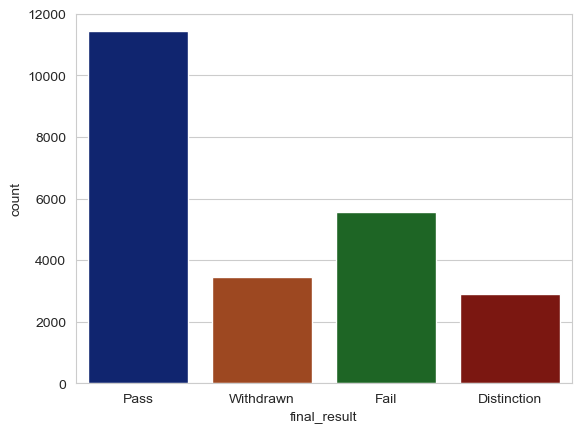

In [35]:
sns.countplot(x='final_result',
              data = stu,
             palette='dark')

Text(0.5, 1.0, 'Relationship between vle interaction and final results')

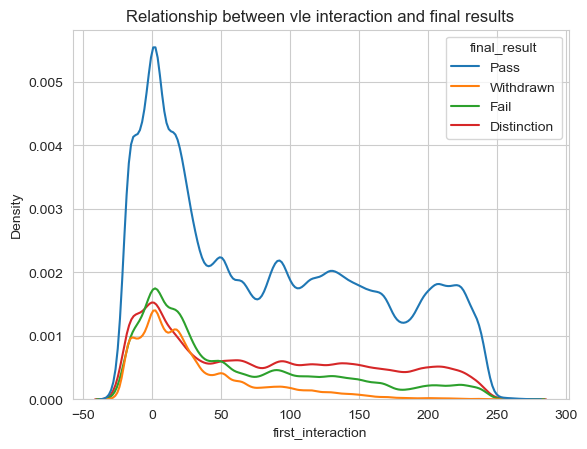

In [37]:
sns.kdeplot(data=full_info,
            x='first_interaction',
            hue = 'final_result').set_title('Relationship between vle interaction and final results')

Text(0.5, 1.0, 'Relationship between vle interaction and first interaction')

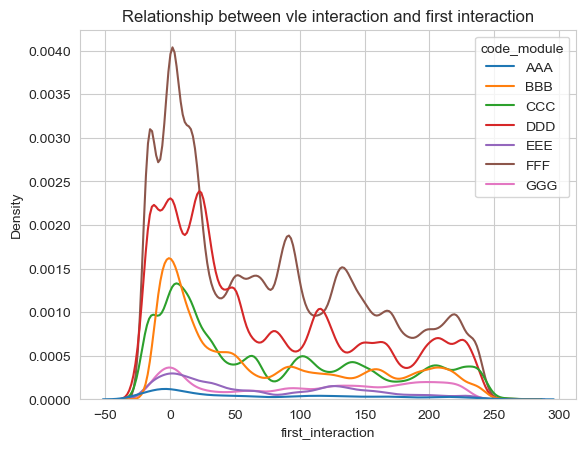

In [38]:
sns.kdeplot(data=full_info,
            x='first_interaction',
            hue = 'code_module').set_title('Relationship between vle interaction and first interaction')

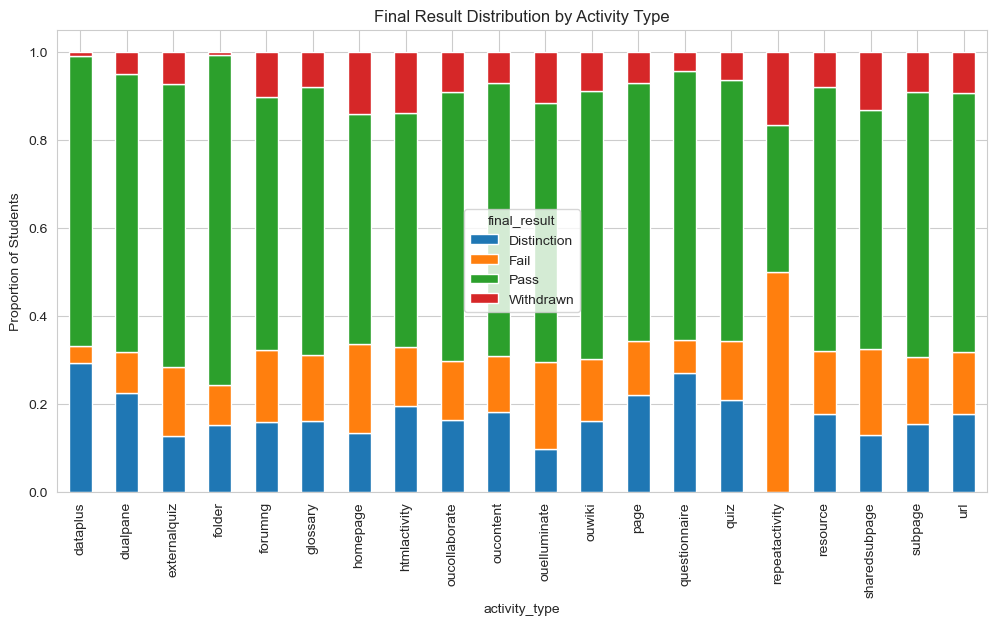

In [136]:
# 4. How activity types affect final results (requires further clarification on 'activity types')
vle_activity_results = full_info.groupby('activity_type')['final_result'].value_counts(normalize=True).unstack()
vle_activity_results.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Final Result Distribution by Activity Type')
plt.ylabel('Proportion of Students')
plt.show()


In [143]:
activity_dp = full_info[full_info['activity_type']=='dataplus']
activity_dp = activity_dp[['id_site','sum_click']].groupby('id_site').sum().sort_values(by='sum_click',
                                                                          ascending = False).head(10).reset_index()

activity_dp

,id_site,sum_click
0,883302,15518
1,717016,12855
2,527526,12145
3,779678,6691
4,883301,4958
5,717017,4095
6,527524,3448
7,883306,2828
8,883303,2334
9,717014,2284


<Axes: xlabel='id_site', ylabel='sum_click'>

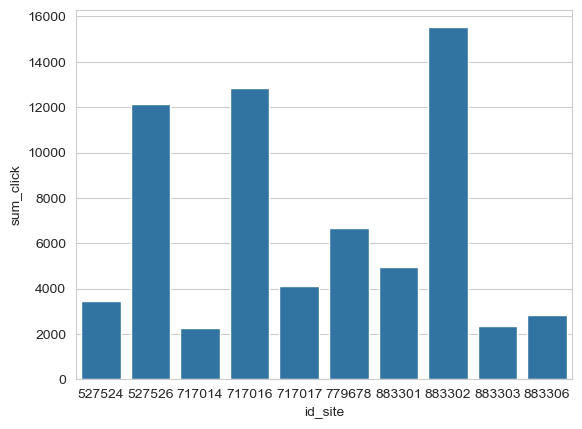

In [144]:
sns.barplot(x = 'id_site',y='sum_click',data = activity_dp)

In [139]:
activity_df = full_info[full_info['activity_type']=='repeatactivity']
activity_df = activity_df[['id_site','sum_click']].groupby('id_site').sum().sort_values(by='sum_click',
                                                                          ascending = False).head(10).reset_index()

activity_df

,id_site,sum_click
0,716409,10
1,716420,2
2,716423,2
3,883099,2
4,883102,2


In [140]:
site_rel = full_info[full_info['id_site']=='716409']
site_rel['activity_type'].value_counts()

Series([], Name: count, dtype: int64)

<Axes: xlabel='id_site', ylabel='sum_click'>

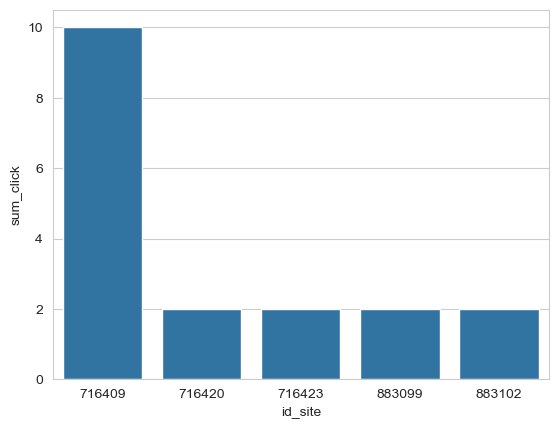

In [141]:
sns.barplot(x = 'id_site',y='sum_click',data = activity_df)

<Axes: xlabel='code_module', ylabel='count'>

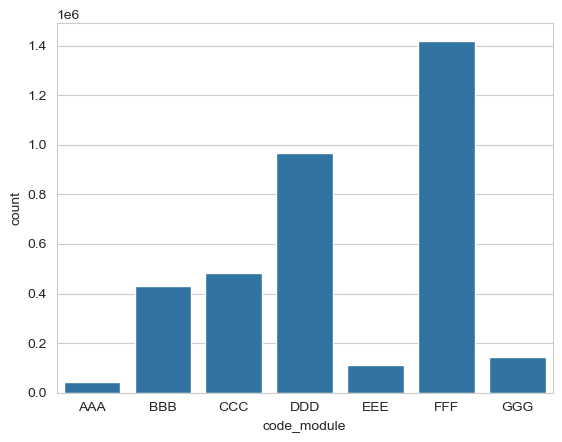

In [39]:
sns.countplot(x='code_module',data = full_info)

### Model building


In [40]:

#Feature Selection
#Feature Selection
features = full_info.groupby(['id_student','code_module','code_presentation']).max().reset_index()

features = features.drop(['id_student','date_registration','date_unregistration','week_from','week_to','id_assessment',
                           'is_banked','first_interaction'],axis = 1)

In [41]:
features.head(2)

,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,id_site,sum_click,activity_type,assessment_type,date_of_submission,weight,module_presentation_length,date_submitted,score,e_l_submission
0,AAA,2014J,M,Scotland,HE Qualification,80-90%,55<=,0,60,N,Pass,1010323,497,url,TMA,114.200000,20.000000,269.0,111.6,61.800000,2.600000
1,DDD,2013J,M,London Region,HE Qualification,30-40%,55<=,0,90,N,Withdrawn,674449,184,url,TMA,55.333333,13.333333,261.0,55.0,87.666667,0.333333


In [42]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mn = MinMaxScaler()
scaler = StandardScaler
features[['studied_credits','sum_click','module_presentation_length','weight']]=mn.fit_transform(features[['studied_credits',
                                                                                                           'sum_click',
                                                                                                           'module_presentation_length','weight']])


In [43]:
cat_col = ['code_module','code_presentation','gender','region','highest_education','imd_band',
           'age_band','disability','final_result','activity_type','assessment_type','id_site']
lb = LabelEncoder()
for col in cat_col:
    features[col]=lb.fit_transform(features[col])

features.head()

,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,id_site,sum_click,activity_type,assessment_type,date_of_submission,weight,module_presentation_length,date_submitted,score,e_l_submission
0,0,3,1,6,1,8,2,0,0.05,0,2,790,0.059295,8,2,114.200000,0.200000,1.000000,111.6,61.800000,2.600000
1,3,1,1,3,1,3,2,0,0.10,0,3,217,0.021877,8,2,55.333333,0.133333,0.771429,55.0,87.666667,0.333333
2,3,3,1,3,1,3,2,1,0.05,0,3,580,0.000717,2,2,58.500000,0.125000,0.800000,-1.0,86.500000,59.500000
3,0,1,1,0,1,9,2,0,0.35,0,2,125,0.024507,8,2,114.200000,0.200000,0.971429,112.4,82.000000,1.800000
4,1,0,0,0,2,2,0,2,0.05,0,1,66,0.004184,7,2,71.500000,0.115000,0.171429,77.5,100.000000,-1.000000


In [44]:
features.head(2)

,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,id_site,sum_click,activity_type,assessment_type,date_of_submission,weight,module_presentation_length,date_submitted,score,e_l_submission
0,0,3,1,6,1,8,2,0,0.05,0,2,790,0.059295,8,2,114.200000,0.200000,1.000000,111.6,61.800000,2.600000
1,3,1,1,3,1,3,2,0,0.10,0,3,217,0.021877,8,2,55.333333,0.133333,0.771429,55.0,87.666667,0.333333


<Axes: >

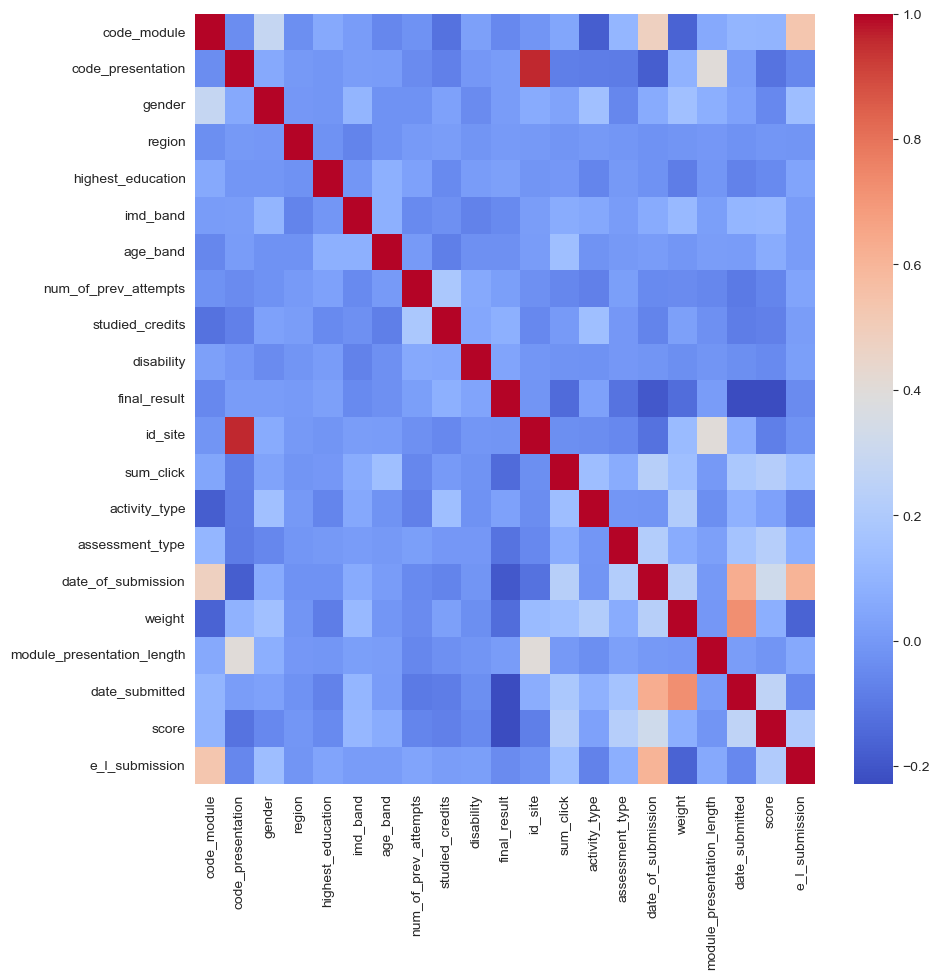

In [45]:
cor = features.corr()
plt.figure(figsize = (10,10))
sns.heatmap(cor,cmap = 'coolwarm')

### model building

In [46]:
!pip install -q keras-tcn --no-dependencies

In [130]:
x = features.drop('final_result',axis = 1)
y = features['final_result']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2, random_state = 40)
print(len(x_train))
print(len(x_test))

20634
5159


In [92]:
x_train.shape

(20634, 20)

rus = RandomUnderSampler()
x_train_rus,y_train_rus = rus.fit_resample(x_train,y_train)
y_train_rus.value_counts()

In [49]:
rfc = RandomForestClassifier()
rfc.fit(x_train,y_train)
rfc_pred = rfc.predict(x_test)
print(classification_report(y_test,rfc_pred))

              precision    recall  f1-score   support

           0       0.62      0.43      0.51       614
           1       0.59      0.44      0.51      1132
           2       0.77      0.90      0.83      2487
           3       0.65      0.67      0.66       926

    accuracy                           0.70      5159
   macro avg       0.66      0.61      0.63      5159
weighted avg       0.69      0.70      0.69      5159



In [50]:
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
# Training the model
xgb.fit(x_train, y_train)

# Making predictions
xgb_pred = xgb.predict(x_test)
print(classification_report(y_test,xgb_pred))

              precision    recall  f1-score   support

           0       0.68      0.35      0.46       614
           1       0.63      0.39      0.48      1132
           2       0.75      0.94      0.83      2487
           3       0.65      0.73      0.69       926

    accuracy                           0.71      5159
   macro avg       0.68      0.60      0.62      5159
weighted avg       0.70      0.71      0.69      5159



In [84]:
from tcn import TCN

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Input


1 20634


In [133]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))


In [119]:
x_train_reshaped = x_train.values.reshape( x_train.shape[0],1, x_train.shape[1])
x_test_reshaped = x_test.values.reshape( x_test.shape[0],1, x_test.shape[1])


In [113]:
x_train_reshaped.shape

(1, 20634, 20)

In [111]:
y_train.shape

(20634,)

In [135]:
# Define a TCN model
model = Sequential([
    TCN(nb_filters=64,           # Number of filters
        kernel_size=3,           # Kernel size for convolutions
        dilations=[1, 2, 4, 8],  # Dilation factor to expand the receptive field
        activation='relu',
        input_shape=(x_train_reshaped.shape[1], x_train_reshaped.shape[2])), # input_shape = (timesteps, features)
    Flatten(),                       # Flatten before fully connected layers
    Dense(128, activation='relu'),    # Additional Dense layer
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation = 'softmax')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', metrics=['accuracy'],loss='categorical_crossentropy')

# Train the model
model.fit(x_train_reshaped, y_train, epochs=10, batch_size=32, validation_data=(x_test_reshaped, y_test))

Epoch 1/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 35s 34ms/step - accuracy: 0.2207 - loss: 0.0000e+00 - val_accuracy: 0.2194 - val_loss: 0.0000e+00
Epoch 2/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.2213 - loss: 0.0000e+00 - val_accuracy: 0.2194 - val_loss: 0.0000e+00
Epoch 3/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - accuracy: 0.2208 - loss: 0.0000e+00 - val_accuracy: 0.2194 - val_loss: 0.0000e+00
Epoch 4/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 35s 25ms/step - accuracy: 0.2241 - loss: 0.0000e+00 - val_accuracy: 0.2194 - val_loss: 0.0000e+00
Epoch 5/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.2185 - loss: 0.0000e+00 - val_accuracy: 0.2194 - val_loss: 0.0000e+00
Epoch 6/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.2245 - loss: 0.0000e+00 - val_accuracy: 0.2194 - val_loss: 0.0000e+00
Epoch 7/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.2225 - loss: 0.0000e+00 - val_accuracy: 0.2194 - val_loss: 0.0000e+00
Epoch 8/10
645/645 ━━━━━━━━━━━━━━━

In [124]:
# Make predictions and generate the classification report
y_pred = model.predict(x_test_reshaped)
y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to binary values

# Print the classification report
print(classification_report(y_test, y_pred))

162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       614
           1       0.22      1.00      0.36      1132
           2       0.00      0.00      0.00      2487
           3       0.00      0.00      0.00       926

    accuracy                           0.22      5159
   macro avg       0.05      0.25      0.09      5159
weighted avg       0.05      0.22      0.08      5159



In [153]:
y_train

2352     2
12592    3
24470    2
14271    1
11944    1
16107    0
10344    2
2908     0
2875     1
4191     3
2430     2
1824     3
6778     1
12037    2
25532    3
12787    3
21868    2
25689    2
11621    2
1982     3
23167    2
9039     1
15125    3
8287     2
8271     3
22728    1
13495    0
13050    1
19738    2
3115     0
21077    3
24411    2
17523    2
24211    1
21703    2
9943     1
12616    3
19450    2
15276    2
6433     2
20508    0
2010     2
8295     3
17141    2
16693    3
15460    1
25433    0
16416    2
17136    2
21939    2
4755     1
4239     3
9243     3
6399     3
5528     2
5849     0
7928     1
2182     1
13591    2
8078     1
17352    3
14214    2
18614    2
9510     0
3255     2
18942    1
15145    0
6583     3
6676     2
25622    2
7302     2
16891    0
11438    2
8211     3
1375     2
10524    2
17343    3
5903     2
15651    1
12964    2
6858     2
13406    3
4874     2
552      2
18470    2
22498    3
685      2
8780     0
23658    2
1411     3
14553    2

### Data Preprocessing 2

In [ ]:
index_columns = ['code_module', 'code_presentation', 'id_student']

# Step 2: Check for 'id_student' in DataFrames
for df in [student_assessment, student_info, student_registration, student_vle]:
    if 'id_student' not in df.columns:
        raise KeyError("The column 'id_student' is missing from one of the dataframes.")

In [ ]:
# Step 3: Merge student_info and student_registration with courses
full_registrations = pd.merge(student_info, student_registration, on=index_columns, validate='1:1')
full_registrations = pd.merge(full_registrations, courses, on=['code_module', 'code_presentation'], validate='many_to_one')
full_registrations.dropna(subset=['date_registration', 'imd_band'], inplace=True)

In [ ]:
# Step 4: Filter for students who have not withdrawn
not_withdrawn = full_registrations['date_unregistration'].isna()

prediction_window = None  # Example: No prediction window
if prediction_window:
    withdrawn_after_predict = (full_registrations['final_result'] == 'Withdrawn') & \
                              (full_registrations['date_unregistration'] > prediction_window)
else:
    withdrawn_after_predict = (full_registrations['final_result'] == 'Withdrawn') & \
                              (full_registrations['date_unregistration'] > 0)

In [ ]:
full_registrations = full_registrations[not_withdrawn | withdrawn_after_predict]
full_registrations['date_unregistration'].fillna(full_registrations['module_presentation_length'], inplace=True)
full_registrations = full_registrations[full_registrations['date_unregistration'] <= full_registrations['module_presentation_length']]

In [ ]:
# Step 5: Merge student_vle with vle data
if prediction_window:
    student_vle = student_vle[student_vle.date <= prediction_window]

vle = pd.merge(student_vle, vle, how='left', on=['id_site', 'code_module', 'code_presentation'], validate='m:1').drop(columns=['week_from', 'week_to'])

# Step 6: Group by index_columns and calculate total activities, days studied, and clicks
total_activities = vle.groupby(by=index_columns).count().reset_index().drop(columns=['date', 'sum_click', 'activity_type'])
date_grouped = vle.groupby(by=index_columns + ['date']).count().reset_index()
days_studied = date_grouped.groupby(by=index_columns).count().reset_index().drop(columns=['id_site', 'sum_click', 'activity_type'])
clicks = vle.groupby(by=index_columns).sum().reset_index().drop(columns=['id_site', 'date'])

In [ ]:
# Step 7: Merge activities, days studied, and clicks with full_registrations
full_registrations = pd.merge(full_registrations, days_studied, on=index_columns, how='left')
full_registrations = pd.merge(full_registrations, total_activities, on=index_columns, how='left')
full_registrations = pd.merge(full_registrations, clicks, on=index_columns, how='left')

In [ ]:
# Step 8: Merge student assessments with assessments
assessments = pd.merge(student_assessment, assessments, how='left', on='id_assessment')
assessments.dropna(subset=['score'], inplace=True)
assessments.drop(columns=['is_banked'], inplace=True)
if prediction_window:
    assessments = assessments[assessments['date_submitted'] <= prediction_window]

In [ ]:
# Step 9: Process assessment data
assessments['score'] = pd.to_numeric(assessments['score'], errors='coerce')
assessments['date_submitted'] = pd.to_numeric(assessments['date_submitted'], errors='coerce')
assessments['weight'] = pd.to_numeric(assessments['weight'], errors='coerce')

num_assessments = assessments.groupby(by=index_columns).count().reset_index().drop(columns=['assessment_type', 'date', 'weight'])
total_assessments = assessments.groupby(by=['code_module', 'code_presentation']).count().reset_index().drop(columns=['assessment_type', 'date', 'weight'])
total_assessments = total_assessments.rename(columns={'id_assessment': 'total_assessments'})
num_assessments = pd.merge(num_assessments, total_assessments, on=['code_module', 'code_presentation'])
num_assessments['id_assessment'] = num_assessments['id_assessment'] / num_assessments['total_assessments']

In [ ]:
full_registrations.head(2)

In [ ]:
num_assessments.head(2)

In [ ]:
num_assessments.rename(columns = {'id_student_x':'id_student'},inplace = True)

In [ ]:
avg_score.head()

In [ ]:
# Step 10: Calculate average score
avg_score = assessments.groupby(by=index_columns).mean(numeric_only=True).reset_index().drop(columns=['id_assessment', 'date'])

# Step 11: Merge everything into full_registrations
full_registrations = pd.merge(full_registrations, num_assessments, on=index_columns, how='left')
full_registrations = pd.merge(full_registrations, avg_score, on=index_columns, how='left')
full_registrations.fillna(0, inplace=True)

# Step 12: Rename columns
new_cols = {'id_assessment': 'assessments_completed', 'score': 'average_assessment_score', 'date': 'days_studied', 'id_site': 'activities_engaged','sum_click': 'total_clicks'}
full_registrations.rename(columns=new_cols, inplace=True)

# Step 13: Apply thresholds to remove outliers
full_registrations = full_registrations[(full_registrations['total_clicks'] < 4035) & (full_registrations['activities_engaged'] < 1135)]

# Return the final dataframe
full_registrations.head(10)

In [ ]:
full_registrations.columns

In [ ]:
pd.drop(['date_submitted_x','id_student_y','date_submitted_y',

In [ ]:

full_registrations.head(5)